In [1]:
%matplotlib inline  
import os
import pandas as pd
import yfinance as yf
import sqlite3
import re
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle
import logging
import pyarrow as pa
import pyarrow.parquet as pq
from scipy import stats
from scipy.signal import savgol_filter
import datetime
logger = logging.getLogger()


For every sector, group stocks together by sector and average the correlation distributions. Also calculate average distribution across all stocks.

For every ticker, compare its distribution of correlations to the global average and to the average of the corresponding sector.

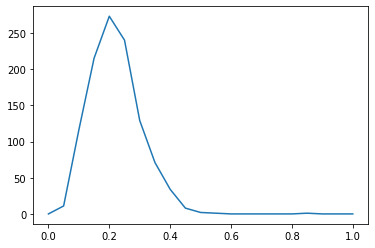

In [102]:
# load data
# parameters
# ============================================================
window_size = 10
ticker = "GME"
start_date = datetime.datetime(day=1, month=1, year=2021)
end_date = datetime.datetime(day=1, month=6, year=2021)
# ============================================================

table = pq.read_table(f'./data/{window_size}/{ticker}.parquet')
df = table.to_pandas()
df = df.iloc[2:,:] # first couple values are garbage

if start_date is not None:
    df = df[df.index>=start_date]
if end_date is not None:
    df = df[df.index<end_date]
    
df = df.drop("EHAB", axis=1)
#df = df.drop("U", axis=1)
dist = dict()
dist['bins'] = np.arange(-1.0, 1.01, .01)

ticker_info = pd.read_csv('stock_monitor_tickers.csv')
#ticker_info = pd.read_csv('yahoo_tickers_updated.csv')

#ticker_info.loc[ticker_info['Symbol']=='AMC', 'Sector']
sectors = ticker_info['Sector'].unique()

# get global distribution 
global_corr = np.reshape(df.to_numpy(), [-1,1])
global_n, _ = np.histogram(global_corr, bins=dist['bins'])
global_n = global_n/np.sum(global_n)
dist['Global'] = global_n

# get distributions for each sector
ticker_pool = set(df.columns)
for sector in sectors:    
    idx = ticker_info['Sector']==sector
    sector_tickers = set(ticker_info.loc[idx, 'Symbol'])
    valid_tickers = list(sector_tickers & ticker_pool)
    if ticker in valid_tickers:
        valid_tickers.remove(ticker)
    sector_corr = np.reshape(df[valid_tickers].to_numpy(), [-1,1])
    sector_n,_ = np.histogram(sector_corr, bins=dist['bins'])
    sector_n = sector_n/np.sum(sector_n)
    dist[sector] = sector_n    


# for every symbol, get is correlation distribution
# smooth it out a little with 1st-order savitzky-golay (moving average)
global_res = pd.DataFrame(columns=['ks','p'], index=df.columns)
sector_res = pd.DataFrame(columns=['ks','p'], index=df.columns)

for symbol in df.columns:            
    n, _ = np.histogram(df[symbol], dist['bins'])
    if sum(n)==0:
        continue           
    n = savgol_filter(n, 51, 1)
    n = n/np.sum(n)
    r = stats.kstest(dist['Global'], n)
    global_res.loc[symbol, 'ks'] = r.statistic
    global_res.loc[symbol, 'p'] = r.pvalue
    
    sector = ticker_info.loc[ticker_info['Symbol']==symbol, 'Sector']
    if len(sector)==0:
        continue
    sector = sector.iloc[0]
    
    r = stats.kstest(dist[sector], n)
    sector_res.loc[symbol,'ks'] = r.statistic
    sector_res.loc[symbol,'p'] = r.pvalue

# plot the distribution of KS scores to visually make sure it matches
# also sort tickers based on KS score
r
n, bins = np.histogram(global_res['ks'], bins=np.arange(0,1.1,.05))
plt.plot(bins[0:-1],n)
order = global_res['ks'].sort_values(ascending=False)
out = global_res.loc[order.index]
out = out.drop(ticker)

C:\Users\zackw\AppData\Local\Temp\ipykernel_10416\1001449429.py:19: RuntimeWarning: invalid value encountered in true_divide
  n = n/np.sum(n)


LinAlgError: SVD did not converge in Linear Least Squares

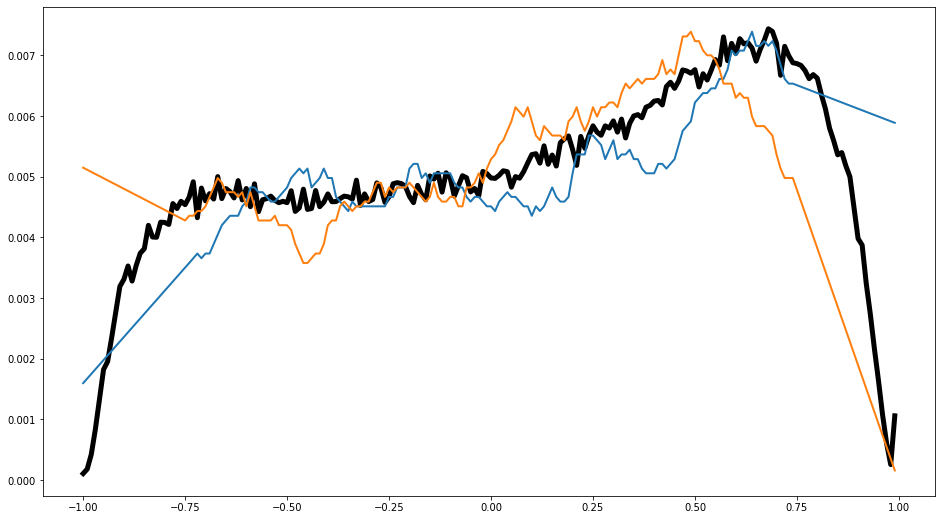

In [103]:
order = global_res['ks'].sort_values(ascending=False)
out = global_res.loc[order.index]
out = out.drop(ticker)

idx=0
while idx<len(out):
    legends = list()
    legends.append("Global")
    figure = plt.figure(figsize=(16,9))
    plt.plot(dist['bins'][0:-1], dist['Global'],color='black',linewidth=5)

    if idx+5>len(out):
        ticker_list = list(out.index[idx:-1])        
    else:
        ticker_list = list(out.index[idx:idx+5])    

    for i in ticker_list:        
        n,_ = np.histogram(df[i], bins=dist['bins'])
        n = n/np.sum(n)
        n = savgol_filter(n, 51, 1)
        plt.plot(dist['bins'][0:-1], n, linewidth=2)    
        legends.append(f"{i}:ks={out.loc[i,'ks']}, p={out.loc[i,'p']}")

    plt.legend(legends,prop={'size': 14})
    title = "Correlation distributions:"
    if start_date is not None:
        start_txt = start_date.strftime("%b-%d-%Y")
    else:
        start_txt = "Beginning"
    if end_date is not None:
        end_txt = end_date.strftime("%b-%d-%Y")
    else:
        end_txt = "Present-Day"
    plt.title(title+" "+start_txt+" to "+end_txt, fontsize=20)
    os.makedirs(f"./plots/global/{window_size}/{start_txt}_to_{end_txt}/", exist_ok=True)
    plt.savefig(f"./plots/global/{window_size}/{start_txt}_to_{end_txt}/{idx}_{idx+4}.png", dpi=200, facecolor="white")
    plt.close()
    idx+=5
    


In [ ]:
legends = list()
legends.append("Global")
figure = plt.figure(figsize=(16,9))
plt.plot(dist['bins'][0:-1], dist['Global'],color='black',linewidth=5)

for i in [-15,-14,-13,-12,-11]:    
    s = out.index[i]
    n,_ = np.histogram(table[s], bins=dist['bins'])
    n = n/np.sum(n)
    n = savgol_filter(n, 51, 2)
    plt.plot(dist['bins'][0:-1], n)    
    legends.append(s+":"+str(out[i]))


plt.legend(legends)

In [ ]:
out.index

In [ ]:
np.where(out.index=='BBI')

In [ ]:
np.where(ticker_info['Sector']=='BBI')